In [1]:
%matplotlib inline
%matplotlib notebook

In [2]:
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import re
import hvplot.pandas
import csv

In [3]:
abs_file = Path("Average weekly ordinary time earnings, full-time adults by state, original.csv")

vehicle_file = Path("Australian Vehicle Prices.csv")


# Define the file paths. Reading in Australian poscode csv from sql
input_file_path = 'australian-postcodes.csv'

output_file_path = 'postcodes_geo.csv'

# Regular expression pattern to extract values from INSERT INTO statements
pattern = r"\('(.*?)', '(.*?)', '(.*?)', (.*?), (.*?)\)"

# List to store extracted data
data = []

# Read the SQL-like file and extract data
with open(input_file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()
    for line in lines:
        match = re.findall(pattern, line)
        if match:
            data.extend(match)

# Write extracted data to a CSV file
with open(output_file_path, mode='w', newline='', encoding='utf-8') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['postcode', 'suburb', 'state', 'latitude', 'longitude'])  # Write header
    writer.writerows(data)  # Write the extracted data

print(f"CSV file '{output_file_path}' has been created.")

CSV file 'postcodes_geo.csv' has been created.


In [4]:
abs_df = pd.read_csv(abs_file, skiprows=1)
abs_df.reset_index(inplace=True)

vehicle_df = pd.read_csv(vehicle_file)


postcode_file = Path("postcodes_geo.csv")
postcode_df = pd.read_csv(postcode_file)

In [5]:
vehicle_df = vehicle_df.dropna(how="any")

Get the average Weekly income of the each State in Australia

In [6]:
abs_df = abs_df.rename(columns={"Unnamed: 0": "State"})

abs_df = abs_df[abs_df['State'] != "Source: Australian Bureau of Statistics, Average Weekly Earnings, Australia May 2023"]

columns_to_convert = ['Persons ($)', 'Males ($)', 'Females ($)']
abs_df[columns_to_convert] = abs_df[columns_to_convert].apply(lambda x: x.str.replace(',', '').astype(float))



In [7]:
print(abs_df.dtypes)

index            int64
State           object
Persons ($)    float64
Males ($)      float64
Females ($)    float64
dtype: object


In [8]:
average_abs = abs_df.drop(columns=["Males ($)", "Females ($)"])

In [9]:
average_abs = average_abs.set_index("State")

In [10]:
new_states = {"Tas.": "TAS", "Vic.": "VIC"}
average_abs = average_abs.rename(index=new_states)
average_abs

,index,Persons ($)
State,,
NSW,0,1831.9
VIC,1,1832.9
Qld,2,1791.0
SA,3,1677.8
WA,4,2039.3
TAS,5,1619.3
NT,6,1775.9
ACT,7,2022.9
Aust.,8,1838.1


In [11]:
average_abs = average_abs.reset_index()

<IPython.core.display.Javascript object>


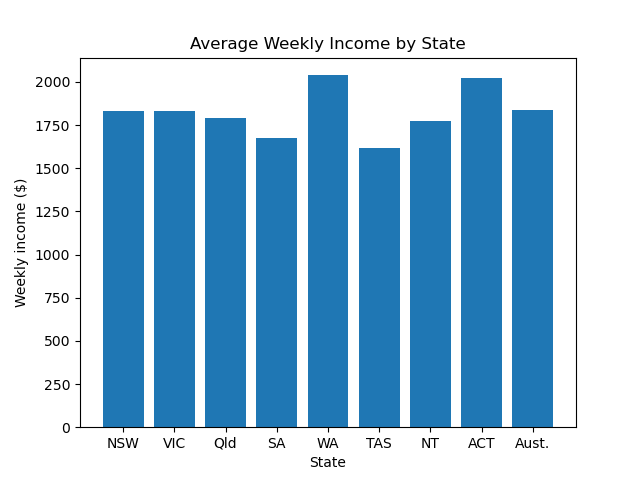

In [12]:
plt.bar(average_abs['State'], average_abs['Persons ($)'])


plt.title("Average Weekly Income by State")
plt.ylabel("Weekly income ($)")
plt.xlabel("State")
plt.show()

The first graph above (figure 1.0) shows the average weekly income by State from the Australian Buruea of Statistics (ABS). The data displays each state of Australia and their average weekly income. Western Austalia (WA) and Australian Capital Territory (ACT) has the highest weekly average income out of the other Australian states. Although ACT is one of higher average weekly income, this could be a result of the lower population density and high valued occupations in the state. Western Australia has the highest average weekly income with $2039.3, the high average weekly income may be affected due to the high income rate of western farmers. Although this is only a speculation to the data, further research may be needed for more data analysis.

The rest of the states are relatively similar to one another, with Tasmania (TAS) and South Australia (SA) having the lowest average weekly income compared to the other states. With an average weekly income of $1619.3, Tasmania has the smallest average income and smaller population compared to the Australia (Aust.). Therefore, the result Tasmania having the least average income makes sense.

The "average weekly income by state", will provide an indicator whether or not the weekly income has any correlation with the price of vehicle by state. Later in this question, a bar graph that showcase the vehicle price by state will be displayed to determine if there are any correlatio or if this there's a pattern in the dataset. 



Finding average vehicle price by State

In [13]:
new = vehicle_df['Location'].str.split(", ", n=1, expand=True)
 
# making separate first name column from new data frame
vehicle_df["Suburb"] = new[0]
 
# making separate last name column from new data frame
vehicle_df["State"] = new[1]
 
# Dropping old Name columns
vehicle_df.drop(columns=["Location"], inplace=True)


In [14]:
vehicle_df = vehicle_df.drop(columns=["UsedOrNew", "Transmission", "Engine",
                                             "DriveType", "FuelType", "ColourExtInt", "CylindersinEngine", "BodyType", "FuelConsumption", "Doors","Seats","Kilometres"])

In [15]:
vehicle_df.info

<bound method DataFrame.info of                Brand    Year    Model               Car/Suv  \
0          Ssangyong  2022.0   Rexton  Sutherland Isuzu Ute   
1                 MG  2022.0      MG3             Hatchback   
2                BMW  2022.0     430I                 Coupe   
3      Mercedes-Benz  2011.0     E500                 Coupe   
4            Renault  2022.0   Arkana                   SUV   
...              ...     ...      ...                   ...   
16727        Hyundai  2015.0      I30                 Wagon   
16728         Nissan  2021.0  Qashqai                   SUV   
16731         Suzuki  2022.0   Vitara   Bremer Suzuki - New   
16732  Mercedes-Benz  2016.0   GLC250                   SUV   
16733  Mercedes-Benz  2021.0     C200                 Sedan   

                                           Title   Price          Suburb State  
0           2022 Ssangyong Rexton Ultimate (awd)   51990       Caringbah   NSW  
1      2022 MG MG3 Auto Excite (with Navigation) 

In [16]:
vehicle_df['Price'] = pd.to_numeric(vehicle_df['Price'], errors='coerce')

In [17]:
vehicle_df['Price'] = vehicle_df['Price'].fillna(0).astype(int)

In [18]:
aus_vehicle_agg = vehicle_df.groupby("State")['Price'].agg(["mean", "median", "var","std","sem"])

In [19]:
aus_vehicle_agg = aus_vehicle_agg.reset_index()

In [20]:
merged_df = pd.merge(aus_vehicle_agg, average_abs, on="State")
merged_df

,State,mean,median,var,std,sem,index,Persons ($)
0,ACT,32844.755682,27990.0,5.912441e+08,24315.511855,1296.021136,7,2022.9
1,NSW,35471.112187,27990.0,1.051885e+09,32432.771220,430.413976,0,1831.9
2,NT,35121.208333,28395.0,5.472293e+08,23392.933666,2756.883671,6,1775.9
3,SA,32059.045932,26980.0,7.669564e+08,27693.977484,1003.246952,3,1677.8
4,TAS,37521.620690,33990.0,4.705276e+08,21691.647448,1522.455188,5,1619.3
5,VIC,35318.222936,29990.0,8.279471e+08,28774.070377,491.523458,1,1832.9
6,WA,37372.942910,30988.0,6.460641e+08,25417.790474,629.763162,4,2039.3


In [21]:
merged_df= merged_df.rename(columns={"mean": "Average"})

<IPython.core.display.Javascript object>


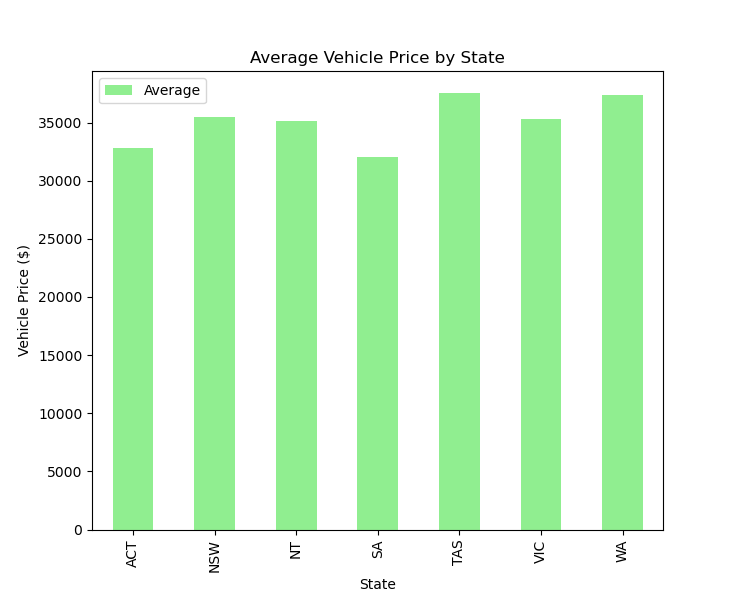

Text(0.5, 1.0, 'Average Vehicle Price by State')

In [22]:
average_income_vehicle_price_state = merged_df.plot(kind="bar", x="State", y=["Average"], color='lightgreen')

plt.ylabel("Vehicle Price ($)")
plt.xlabel("State")
plt.title("Average Vehicle Price by State")

After finding the average weekly income by state, the next graph will be the vehicle prices by state (figure 1.1). The purpose of this graph is to find whether there's a pattern with the average weekly income and the average vehicle prices. In this graph, Western Australia has the highest vehicle prices on with $37,372.94$. The given result suggest that, WA has the highest average weekly income and the highest vehicle prices as well. However, Tasmania has a high vehicle price and the average weekly income for the state is lower than the average Australian weekly income (figure 1.0). The average weekly income for Tasmania is $1,619.3$ meanwhile the average vehicle price of Tasmania is $37,521.62$ which makes earning a vehicle in TAS more difficult compared to the rest of states. 

South Austalia has the lowest average vehicle prices with $32,059.04$ which correlates with the low weekly income of the state with only $1677.8$ on average weekly. Australia Capital Territory however has a low average vehicle price with $32844.75$ and a high average weekly income with $2,022.9$. This could be due to the population density and the lack of expensive cars imported into the state. 

The average vehicle price by state is less accurate than finding which location of Australia's suburbs have the highest vehicle price. The next graph will showcase the suburbs of which the highest vehicle prices are located in Australia. 

Finding the top Vehicle Prices by Suburb

In [23]:
postcode_df = postcode_df.rename(columns={"suburb": "Suburb"})
postcode_df

,postcode,Suburb,state,latitude,longitude
0,200,Australian National University,ACT,-35.28,149.12
1,221,Barton,ACT,-35.20,149.10
2,800,Darwin,NT,-12.80,130.96
3,801,Darwin,NT,-12.80,130.96
4,804,Parap,NT,-12.43,130.84
...,...,...,...,...,...
16737,9023,Brisbane GPO Boxes,QLD,0.00,0.00
16738,9464,Northgate MC,QLD,0.00,0.00
16739,9726,Gold Coast MC,QLD,0.00,0.00
16740,9728,Gold Coast MC,QLD,0.00,0.00


In [24]:
postcode_duplicates = postcode_df.drop_duplicates(subset="Suburb")
postcode_duplicates

,postcode,Suburb,state,latitude,longitude
0,200,Australian National University,ACT,-35.28,149.12
1,221,Barton,ACT,-35.20,149.10
2,800,Darwin,NT,-12.80,130.96
4,804,Parap,NT,-12.43,130.84
5,810,Alawa,NT,-12.38,130.88
...,...,...,...,...,...
16690,8009,Flinders Lane,VIC,-37.82,144.96
16691,8010,Law Courts,VIC,-38.19,146.29
16692,8011,Little Lonsdale Street,VIC,-37.81,144.96
16730,9016,Brisbane GPO Boxes,QLD,0.00,0.00


In [25]:
grouped_suburb = vehicle_df.groupby('Suburb').apply(lambda x: x.reset_index(drop=True))

def calculate_numeric_price(group):
    numeric_prices = pd.to_numeric(group['Price'], errors='coerce')
    numeric_prices = numeric_prices[~np.isnan(numeric_prices)]
    if numeric_prices.empty:
        return pd.Series({'Numeric_Price_Mean': np.nan})
    else:
        return pd.Series({'Numeric_Price_Mean': numeric_prices.mean()})

# Grouping by 'Suburb' and calculating mean of numeric prices
numeric_price_stats = vehicle_df.groupby('Suburb').apply(calculate_numeric_price).reset_index()

# print(numeric_price_stats)
pd.DataFrame(numeric_price_stats)

numeric_price_stats_sorted = numeric_price_stats.sort_values(by='Numeric_Price_Mean', ascending=False)
print(pd.DataFrame(numeric_price_stats_sorted))

              Suburb  Numeric_Price_Mean
436  Rushcutters Bay       250849.090909
200     Geelong West       152356.000000
310         Medindie       127688.000000
362         Nedlands       123200.000000
67          Brisbane       118500.000000
..               ...                 ...
135          Craigie         4999.000000
261       Kellyville         4332.333333
350     Mount Louisa         4171.428571
284          Leumeah         4033.333333
546   Wentworthville         3083.888889

[582 rows x 2 columns]


In [26]:
grouped_suburb = vehicle_df.loc[:, "Suburb"]

grouped_suburb.describe()

count           14586
unique            582
top       Minchinbury
freq              503
Name: Suburb, dtype: object

In [27]:
lon_lat_merged = pd.merge(grouped_suburb, postcode_duplicates, on="Suburb", how="inner")

lon_lat_merged = lon_lat_merged.drop_duplicates()

unique_suburbs =lon_lat_merged['Suburb'].nunique()
unique_suburbs

569

In [28]:
merged_coordinates_aus_vehicle = pd.merge(vehicle_df, lon_lat_merged, on="Suburb", how="inner")

merged_coordinates_aus_vehicle['Price'] = pd.to_numeric(merged_coordinates_aus_vehicle['Price'], errors='coerce')

In [29]:
grouped_suburb = merged_coordinates_aus_vehicle.groupby(["Suburb"])


agg_price_loc = grouped_suburb['Price'].agg(["mean", "median", "var","std","sem"])

suburb_grouped = vehicle_df.groupby(["Suburb"])

agg_price_loc

# mean_suburb_price = suburb_grouped['Price'].mean()

# suburb_grouped['Price'] = suburb_grouped['Price'].replace('POA', pd.NA)

,mean,median,var,std,sem
Suburb,,,,,
Acacia Ridge,36877.676471,34980.0,4.505689e+08,21226.607867,3640.333217
Adamstown,20204.285714,18990.0,9.095055e+07,9536.799749,2548.816945
Adelaide,61558.400000,36490.0,5.149361e+09,71759.051042,16045.811613
Albert Park,30740.000000,26990.0,1.311750e+08,11453.165501,4675.735236
Albion,45011.972222,36419.0,2.042553e+09,45194.611114,7532.435186
...,...,...,...,...,...
Yarraville,17740.000000,17740.0,1.125000e+06,1060.660172,750.000000
Yass,33463.333333,33990.0,1.770980e+08,13307.818504,7683.272596
Yatala,32707.000000,23980.0,5.168794e+08,22734.982941,11367.491471


In [30]:
top_highest_price = agg_price_loc['mean'].nlargest(10)
top_highest_price = pd.DataFrame(top_highest_price)
top_highest_price

,mean
Suburb,
Rushcutters Bay,250849.090909
Geelong West,152356.000000
Medindie,127688.000000
Nedlands,123200.000000
Brisbane,118500.000000
Fullarton,103990.000000
Auburn,103169.708333
Sydney,99669.714286
Carlton,94007.047619


In [31]:
top_price_location = pd.merge(top_highest_price, merged_coordinates_aus_vehicle, on="Suburb", how="inner")
top_price_location['Suburb'].unique()

array(['Rushcutters Bay', 'Geelong West', 'Medindie', 'Nedlands',
       'Brisbane', 'Fullarton', 'Auburn', 'Sydney', 'Carlton', 'Tyabb'],
      dtype=object)

In [32]:
top_price_location.hvplot.points("longitude", "latitude", geo=True, tiles = "OSM",frame_width = 800,frame_height = 800)

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [longitude,latitude]

The map above describes the location of the top 10 highest average vehicle prices located by suburbs. The data shows that numerous high vehicle prices are located in Sydney, Melbourne and Perth. The highest average vehicle price being the Rushcutters Bay with an average of $250,849.09$ in Sydney NSW. Whilst Geelong West having the second highest average vehicle prices with an average of $152,356.0$ and Medindine having the third highest average vehicle price with $127688.0$. Surprisingly the suburb with the highest average vehicle price from Perth is the Nedlands, with an average vehicle price of $123,200.00$. 

<IPython.core.display.Javascript object>


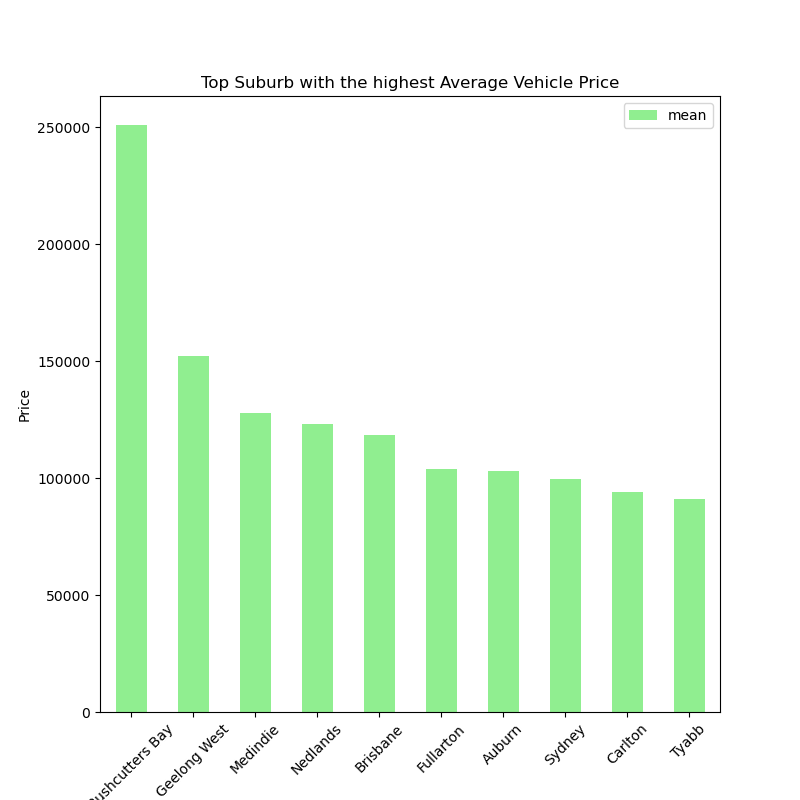

In [33]:
top_highest_price.plot(kind="bar", color="lightgreen", figsize=(8,8))
plt.xticks(rotation=45)

plt.title("Top Suburb with the highest Average Vehicle Price")
plt.ylabel("Price")
plt.xlabel("Top Suburb")

plt.show()

In [34]:
top_highest_price=top_highest_price.reset_index()
top_highest_price

,Suburb,mean
0,Rushcutters Bay,250849.090909
1,Geelong West,152356.000000
2,Medindie,127688.000000
3,Nedlands,123200.000000
4,Brisbane,118500.000000
5,Fullarton,103990.000000
6,Auburn,103169.708333
7,Sydney,99669.714286
8,Carlton,94007.047619
9,Tyabb,90990.000000


<IPython.core.display.Javascript object>


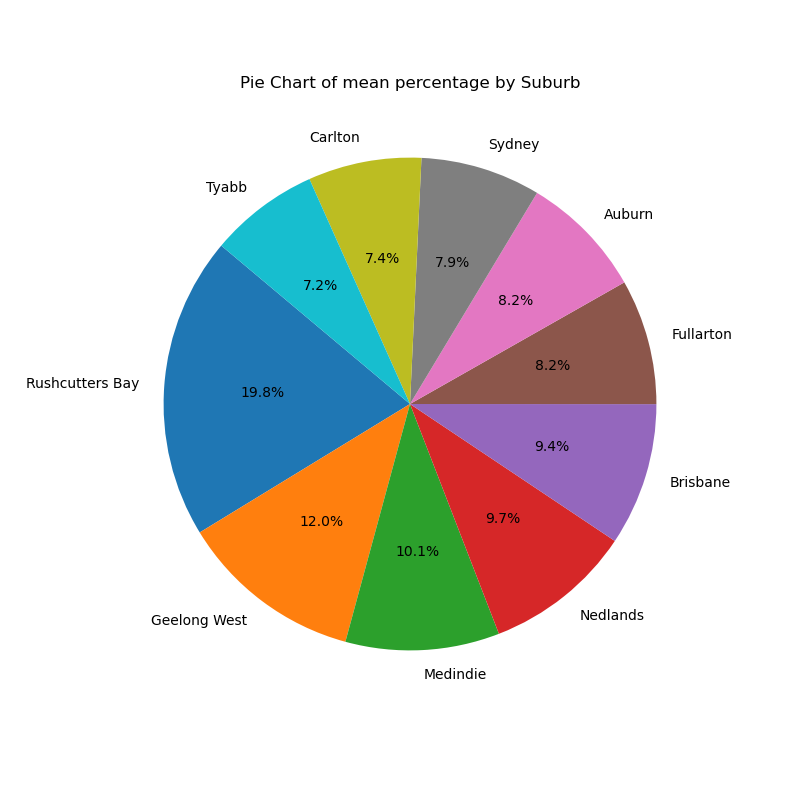

In [35]:
top_highest_price['percentage'] = (top_highest_price['mean'] / top_highest_price['mean'].sum()) * 100

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_highest_price['percentage'], labels=top_highest_price['Suburb'], autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of mean percentage by Suburb')
plt.show()

The final graph showcases the top 10 highest average vehicle prices by suburbs in a pie chart to display the average price difference compared to other suburbs in the list. 